# model

> The TATR model for table extraction and OCR   

In [1]:
#| default_exp model

In [2]:
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [3]:
#| export
from huggingface_hub import hf_hub_download
from transformers import AutoModelForObjectDetection
import torch
from PIL import Image


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Load model

Let's pull Table Transformer from hugging face. We're using the "no_timm" version, because that's what we say on some other pages...

In [23]:
#| export
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")


# Example with an image from the output folder

In [31]:
file_path = "samples/output/Lipincott, 1905_page_49.png"
image = Image.open(file_path).convert("RGB")

In [24]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size = 800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width,height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [37]:
pixelval = detection_transform(image).unsqueeze(0)
pixelval = pixelval.to(device)
print(pixelval.shape)


torch.Size([1, 3, 800, 484])


In [38]:
with torch.no_grad():
  outputs = model(pixelval)

In [27]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [35]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [36]:
print(objects)

[{'label': 'table', 'score': 0.9949813485145569, 'bbox': [201.7464599609375, 763.2545776367188, 1526.700439453125, 1591.6944580078125]}]


# Try the Model with the entire output folder


In [4]:
import os
import pandas as pd
import numpy as np

directory_path = 'samples/output'
files = []

# Walk through the directory
for dirpath, dirnames, filenames in os.walk(directory_path):
    for filename in filenames:
        files.append(os.path.join(dirpath, filename))


In [39]:
def runModel(files):
    file_path = []
    score_list = []
    for path in files:
        image = Image.open(path).convert("RGB")
        pixelval = detection_transform(image).unsqueeze(0)
        pixelval = pixelval.to(device)
        with torch.no_grad():
            outputs = model(pixelval)
        objects = outputs_to_objects(outputs, image.size, id2label)
        file_path.append(path)
        score_list.append(objects)
    data = pd.DataFrame({"file_path":file_path, "score": score_list})
    data.to_csv(os.path.join(directory_path, "../results.csv"), index=False)
    return data
    

In [40]:
runModel(files)

,file_path,score
0,"samples/output/Lipincott, 1905_page_33.png","[{'label': 'table', 'score': 0.997133970260620..."
1,"samples/output/Lipincott, 1905_page_109.png","[{'label': 'table', 'score': 0.706007897853851..."
2,"samples/output/Lipincott, 1905_page_27.png","[{'label': 'table', 'score': 0.994095444679260..."
3,"samples/output/Lipincott, 1905_page_1.png",[]
4,"samples/output/Lipincott, 1905_page_108.png","[{'label': 'table', 'score': 0.592349767684936..."
...,...,...
121,"samples/output/Lipincott, 1905_page_105.png","[{'label': 'table rotated', 'score': 0.9818976..."
122,"samples/output/Lipincott, 1905_page_17.png",[]
123,"samples/output/Lipincott, 1905_page_16.png","[{'label': 'table', 'score': 0.95307856798172,..."
124,"samples/output/Lipincott, 1905_page_110.png","[{'label': 'table rotated', 'score': 0.8847303..."


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

In [24]:
mydf = pd.read_csv("./samples/results.csv")

In [26]:
def markTable(index, data):
    image_path = data["file_path"][0]
    object = eval(data["score"][0])
    image = Image.open(image_path).convert("RGB")
    visualize_detected_tables(image, object, out_path="./example.jpeg")

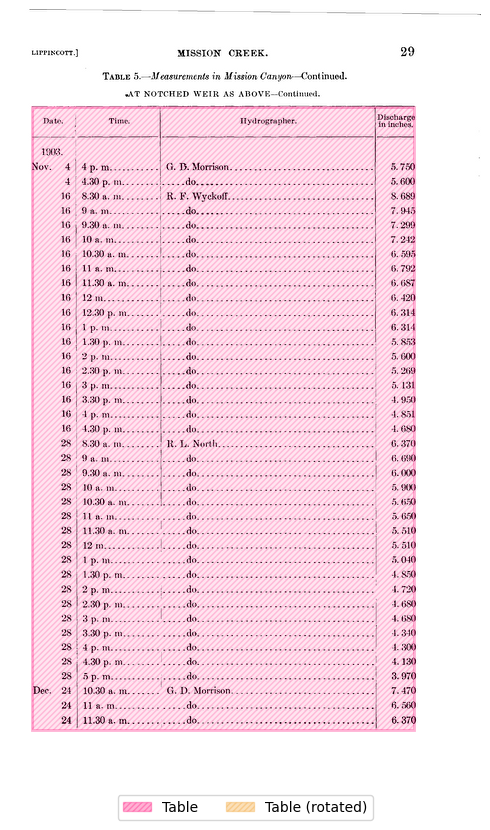

In [27]:
markTable(4, mydf)

In [ ]:
#| export
## put functions and classes here

In [ ]:
#| hide
# Don't show this cell in the docs

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()